In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Layer, LSTMCell, MultiHeadAttention, Dense, LayerNormalization, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
class EnhancedxLSTM(Layer):
    def __init__(self, units, mem_slots=20, num_heads=4, return_sequences=False, **kwargs):
        super(EnhancedxLSTM, self).__init__(**kwargs)
        self.units = units
        self.mem_slots = mem_slots
        self.num_heads = num_heads
        self.return_sequences = return_sequences
        
    def build(self, input_shape):
        if len(input_shape) != 3:
            raise ValueError("Input shape must be 3D: (batch, timesteps, features)")
            
        _, _, self.n_features = input_shape
        
        # LSTM ячейка
        self.lstm_cell = LSTMCell(self.units)
        
        # Внешняя память
        self.memory = self.add_weight(
            name='memory',
            shape=(self.mem_slots, self.units),
            initializer='glorot_uniform',
            trainable=True)
            
        # Механизм внимания
        self.attention = MultiHeadAttention(
            num_heads=self.num_heads,
            key_dim=self.units)
            
        # Проекция для трендов
        self.trend_projection = Dense(self.units, activation='tanh')
        
        # Нормализация
        self.layer_norm = LayerNormalization()
        
        super(EnhancedxLSTM, self).build(input_shape)
        
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        time_steps = inputs.shape[1]
        
        # Инициализация через все признаки последнего наблюдения
        h_state = self.trend_projection(inputs[:, -1, :])
        c_state = tf.zeros((batch_size, self.units))
        
        outputs = []
        for t in range(time_steps):
            # Получаем все признаки для текущего шага
            x = inputs[:, t, :]
            
            # LSTM обработка
            new_h, [_, new_c] = self.lstm_cell(x, [h_state, c_state])
            
            # Residual connection
            h_state = self.layer_norm(h_state + new_h)
            c_state = new_c
            
            # Внимание к памяти
            query = tf.expand_dims(h_state, 1)
            memory = tf.expand_dims(self.memory, 0)
            memory = tf.tile(memory, [batch_size, 1, 1])
            
            # Модуляция трендом
            trend = tf.linspace(0., 1., self.mem_slots)
            trend = tf.reshape(trend, (1, -1, 1))
            modulated_memory = memory * (1. + 0.1 * trend)
            
            attention_out = self.attention(query, modulated_memory, modulated_memory)
            
            # Комбинированный выход
            combined = tf.concat([h_state, tf.squeeze(attention_out, 1)], axis=-1)
            outputs.append(combined)
        
        if self.return_sequences:
            return tf.stack(outputs, axis=1)
        return outputs[-1]
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'units': self.units,
            'mem_slots': self.mem_slots,
            'num_heads': self.num_heads,
            'return_sequences': self.return_sequences
        })
        return config

Подготовка данных

In [4]:
def prepare_multivariate_data(data, target_col, sequence_length=30):
    """
    Подготавливает многомерные временные ряды
    :param data: DataFrame с временными рядами
    :param target_col: имя целевого столбца
    :param sequence_length: длина временного окна
    :return: X, y (признаки и целевая переменная)
    """
    # Масштабирование
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    
    # Создание последовательностей
    X, y = [], []
    for i in range(len(scaled_data)-sequence_length-1):
        X.append(scaled_data[i:(i+sequence_length), :])
        target_idx = data.columns.get_loc(target_col)
        y.append(scaled_data[i + sequence_length, target_idx])
    
    return np.array(X), np.array(y), scaler

Построение модели

In [6]:
def build_model(input_shape, units=64, mem_slots=80):
    model = Sequential([
        Input(shape=input_shape),
        EnhancedxLSTM(units=units, 
                     mem_slots=mem_slots,
                     num_heads=4,
                     return_sequences=True),
        Dropout(0.3),
        EnhancedxLSTM(units=units//2,
                     return_sequences=False),
        Dropout(0.2),
        Dense(32, activation='swish'),
        Dense(1)
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=Huber(),
        metrics=['mae']
    )
    
    return model


Обучение и оценка

In [8]:
def train_and_evaluate(model, X_train, y_train, epochs=100, patience=10):
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True)
    
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Построение графиков обучения
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    return model, history

Прогнозирование

In [10]:
def make_predictions(model, X_test, scaler, target_col_idx, n_future=24):
    last_sequence = X_test[-1]  # Берем последнюю известную последовательность
    predictions = []
    
    for _ in range(n_future):
        # Подготовка входа
        input_data = last_sequence[np.newaxis, ...]
        
        # Прогноз
        pred = model.predict(input_data)[0, 0]
        predictions.append(pred)
        
        # Обновление последовательности
        new_row = np.concatenate([
            last_sequence[1:, :],  # Сдвигаем окно
            np.zeros((1, last_sequence.shape[1]))  # Добавляем новую строку
        ])
        new_row[-1, target_col_idx] = pred  # Заменяем целевой признак
        last_sequence = new_row
    
    # Обратное масштабирование
    dummy_data = np.zeros((len(predictions), X_test.shape[2]))
    dummy_data[:, target_col_idx] = predictions
    predictions = scaler.inverse_transform(dummy_data)[:, target_col_idx]
    
    return predictions

Визуализация фактических и предсказанных значений

In [12]:
def plot_results(data, y_test, predictions, scaler, target_col_idx, n_future):
    try:
        # Создаем dummy массив для обратного преобразования
        dummy_test = np.zeros((len(y_test), scaler.n_features_in_))
        dummy_test[:, target_col_idx] = y_test.flatten()
        
        # Обратное масштабирование
        y_test_inv = scaler.inverse_transform(dummy_test)[:, target_col_idx]
        
        # Визуализация
        plt.figure(figsize=(12, 6))
        plt.plot(data.index[-len(y_test):], y_test_inv, label='Actual', color='blue')

        # Генерация дат для прогноза
        last_date = data.index[-1]
        future_dates = pd.date_range(
            start=last_date + pd.Timedelta(days=1),
            periods=n_future,
            freq='D'  
        )
        
        plt.plot(future_dates, predictions, label='Predicted', color='red', linestyle='--')
        plt.title('Multivariate Time Series Forecasting')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()
        
    except Exception as e:
        print(f"Error in plotting: {str(e)}")
        print(f"Shapes - y_test: {y_test.shape}, predictions: {len(predictions)}")
        print(f"Target column index: {target_col_idx}")
        print(f"Scaler features: {scaler.n_features_in_}")

Визуализация сравнения предсказаний и реальных значений на тестовой выборке

In [14]:
def plot_predictions_vs_actual(data, y_test, test_predictions, scaler, target_col_idx, sequence_length):
    """
    Параметры:
    - data: Исходный DataFrame с временными рядами
    - y_test: Масштабированные тестовые значения целевой переменной
    - test_predictions: Масштабированные предсказания модели
    - scaler: Обученный скейлер
    - target_col_idx: Индекс целевой колонки в данных
    - sequence_length: Длина временного окна
    """
    try:
        # 1. Подготовка данных для обратного преобразования
        dummy_test = np.zeros((len(y_test), scaler.n_features_in_))
        dummy_test[:, target_col_idx] = y_test.flatten()
        
        dummy_pred = np.zeros((len(test_predictions), scaler.n_features_in_))
        dummy_pred[:, target_col_idx] = test_predictions.flatten()
        
        # 2. Обратное масштабирование
        y_test_inv = scaler.inverse_transform(dummy_test)[:, target_col_idx]
        y_pred_inv = scaler.inverse_transform(dummy_pred)[:, target_col_idx]
        
        # 3. Вычисление дат для тестовой выборки
        test_dates = data.index[-len(y_test)-sequence_length:]
        
        # 4. Построение графика
        plt.figure(figsize=(14, 6))
        
        # Фактические значения
        plt.plot(test_dates[sequence_length:], y_test_inv, 
                label='Фактические значения', color='red', linewidth=2)
        
        # Предсказанные значения
        plt.plot(test_dates[sequence_length:], y_pred_inv, 
                label='Предсказания модели', color='green', linewidth=1.5)
        
        # Настройки графика
        plt.title('Сравнение предсказаний и фактических значений', fontsize=14)
        plt.xlabel('Дата', fontsize=12)
        plt.ylabel('Значение целевой переменной', fontsize=12)
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # 5. Вычисление ошибок
        mae = np.mean(np.abs(y_test_inv - y_pred_inv))
        rmse = np.sqrt(np.mean((y_test_inv - y_pred_inv)**2))
        
        print(f'MAE на тестовой выборке: {mae:.2f}')
        print(f'RMSE на тестовой выборке: {rmse:.2f}')
        
    except Exception as e:
        print(f'Ошибка при построении графика: {str(e)}')
        print(f'Размеры данных: y_test={y_test.shape}, preds={test_predictions.shape}')
        print(f'Индекс целевой колонки: {target_col_idx}')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ enhancedx_lstm (EnhancedxLSTM)  │ (None, 30, 128)        │        96,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enhancedx_lstm_1                │ (None, 64)             │        42,240 │
│ (EnhancedxLSTM)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 140,673 (549.50 KB)

 Trainable params: 140,673 (549.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 23s 453ms/step - loss: 0.1775 - mae: 0.4530 - val_loss: 0.0068 - val_mae: 0.1077
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - loss: 0.0272 - mae: 0.1813 - val_loss: 0.0067 - val_mae: 0.1095
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - loss: 0.0178 - mae: 0.1454 - val_loss: 0.0052 - val_mae: 0.0947
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - loss: 0.0113 - mae: 0.1121 - val_loss: 0.0022 - val_mae: 0.0562
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - loss: 0.0079 - mae: 0.0991 - val_loss: 0.0034 - val_mae: 0.0728
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - loss: 0.0077 - mae: 0.0935 - val_loss: 0.0015 - val_mae: 0.0434
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - loss: 0.0064 - mae: 0.0867 - val_loss: 0.0013 - val_mae: 0.0401
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - loss: 0.0064 - mae: 0.0867 - val_loss: 0.0037 - val_mae: 0.0767
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms

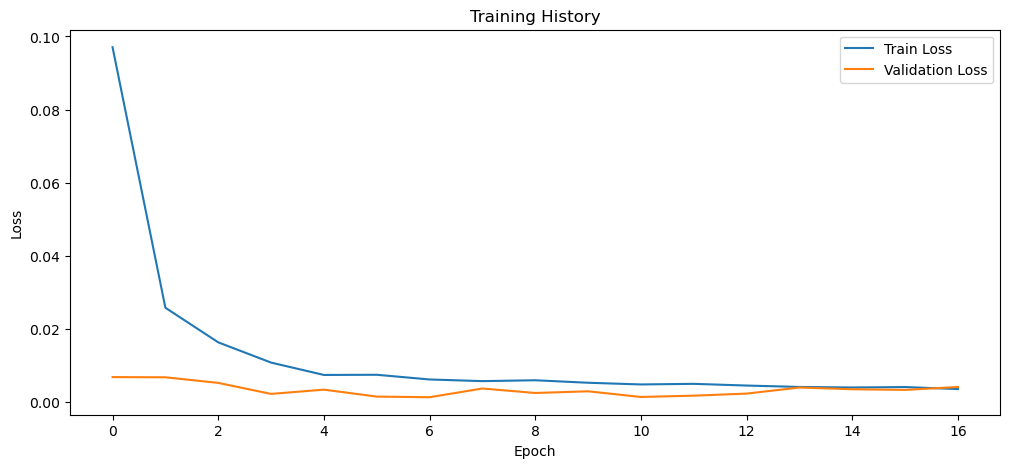

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


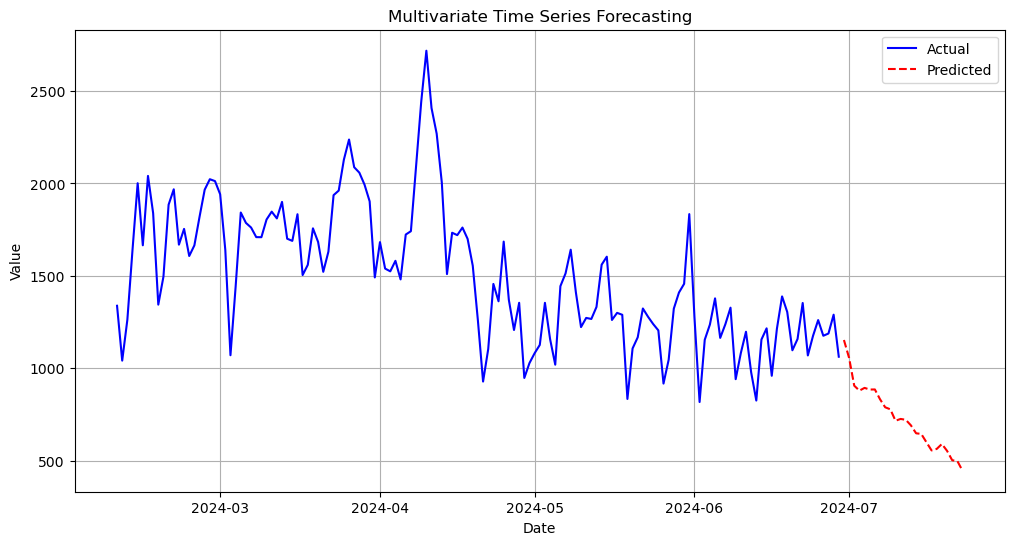

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step


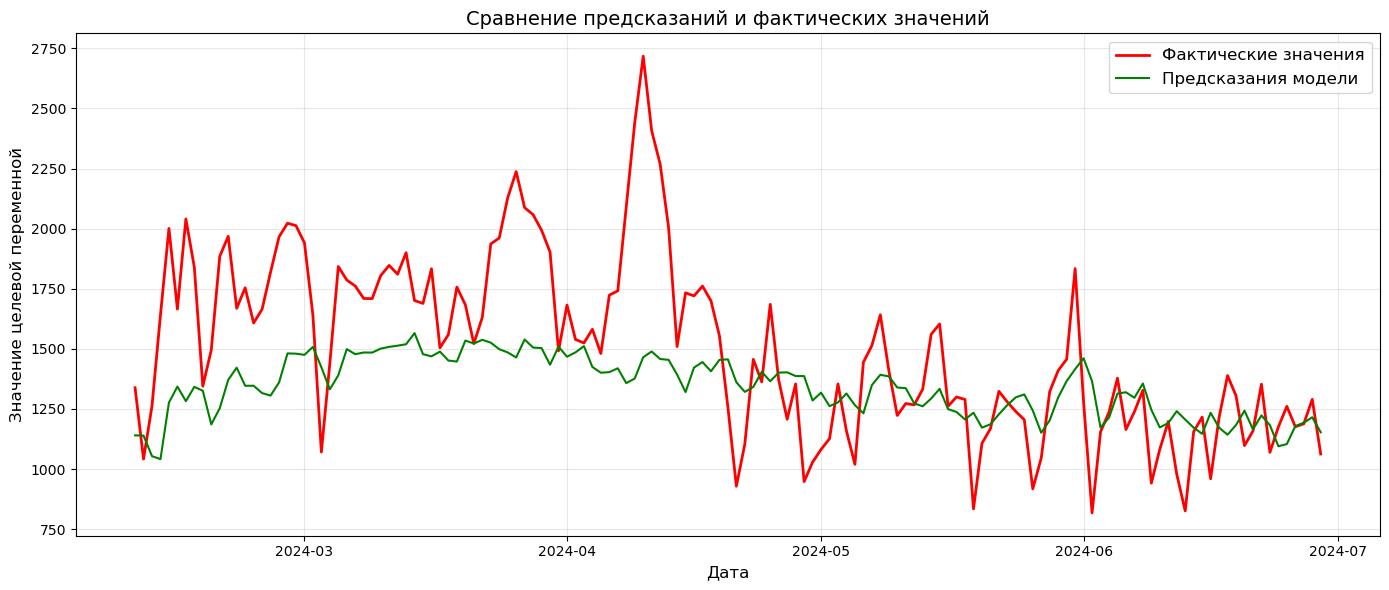

MAE на тестовой выборке: 258.31
RMSE на тестовой выборке: 345.96


In [15]:
if __name__ == "__main__":
    # 1. Загрузка данных 
    data = pd.read_csv('/Users/hyperjacob/Documents/Leroy/dataset3.csv', parse_dates=['course_finished_date'], index_col='course_finished_date')
    target_col = 'course_duration_sum'
    data
    # 2. Подготовка данных
    X, y, scaler = prepare_multivariate_data(data, target_col, sequence_length=30)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    # 3. Построение модели
    model = build_model(input_shape=(X_train.shape[1], X_train.shape[2]))
    model.summary()
    
    # 4. Обучение
    model, history = train_and_evaluate(model, X_train, y_train)
    
    # 5. Прогнозирование и визуализация
    target_col_idx = data.columns.get_loc(target_col)
    predictions = make_predictions(model, X_test, scaler, target_col_idx, n_future=24)

    # Визуализация с обработкой ошибок
    try:
        plot_results(data, y_test, predictions, scaler, target_col_idx, n_future=24)
    except Exception as e:
        print(f"Visualization error: {str(e)}")
        # Альтернативная визуализация только предсказаний
        plt.figure(figsize=(12, 6))
        plt.plot(predictions, label='Predicted')
        plt.title('Predictions Only')
        plt.show()
    # Получение предсказаний на тестовой выборке
    test_predictions = model.predict(X_test)

    # Индекс целевой переменной
    target_col_idx = data.columns.get_loc(target_col)

    # Построение графика
    plot_predictions_vs_actual(data, y_test, test_predictions, scaler, target_col_idx, sequence_length=30)